In [2]:
# Inspect the input data

from utils import plot_loss, encoder_files_to_tensors, normalize_params
import time
import glob
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl


2022-09-19 11:05:38.087481: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-19 11:05:38.090330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-09-19 11:05:38.090341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Initialize parameters
data_dir = '/eos/kiliakis/tomo_data/datasets'

# Data specific
IMG_OUTPUT_SIZE = 128
latent_dim = 7  # 6 + the new VrfSPS

# Keep only a small percentage of the entire dataset
# for faster testing.
dataset_keep_percent = 0.5


In [4]:

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
assert os.path.exists(TRAINING_PATH)

# VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')
# assert os.path.exists(VALIDATION_PATH)



In [5]:
# Create the datasets
# First the training data
files = glob.glob(TRAINING_PATH + '/*.pk')
files = files[:int(len(files) * dataset_keep_percent)]

# Shuffle them
np.random.shuffle(files)
# read input, divide in features/ label, create tensors
x_train, y_train = encoder_files_to_tensors(files, normalize=False)

# # Then the validation data
# files = glob.glob(VALIDATION_PATH + '/*.pk')
# files = files[:int(len(files) * dataset_keep_percent)]

# # Shuffle them
# np.random.shuffle(files)
# # read input, divide in features/ label, create tensors
# x_valid, y_valid = encoder_files_to_tensors(files)


2022-09-19 11:05:40.292558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-09-19 11:05:40.292579: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 11:05:40.292591: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-09-19 11:05:40.292784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
y_train = y_train.numpy()
std_scaler = StandardScaler().fit(y_train)
min_max_scaler = MinMaxScaler().fit(y_train)



In [7]:

print('Mean: ', std_scaler.mean_)
print('STD: ', std_scaler.scale_)
print('Min: ', min_max_scaler.data_min_)
print('Max: ', min_max_scaler.data_max_)

# print(tf.reduce_mean(y_train, 0))
# print(tf.math.reduce_std(y_train, 0))


Mean:  [ 6.54965497e-01 -6.27362736e-01  1.48498051e-09  1.57211821e+11
  6.09828984e+00  2.91956196e+00  8.49900990e+00]
STD:  [2.93490596e+01 5.86655974e+01 1.67224155e-10 8.40424692e+10
 1.78636201e+00 1.10252479e+00 2.02643249e+00]
Min:  [-5.0e+01 -1.0e+02  1.2e-09  1.0e+10  3.0e+00  1.0e+00  5.0e+00]
Max:  [5.0e+01 1.0e+02 1.8e-09 3.0e+11 9.2e+00 5.0e+00 1.2e+01]


phase_error-min_max [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
phase_error-std [-1.7259485  -1.5555853  -1.3852221  -1.2148588  -1.0444956  -0.8741324
 -0.7037692  -0.53340596 -0.36304277 -0.19267955 -0.02231634  0.14804688
  0.3184101   0.4887733   0.65913653  0.8294997   0.9998629   1.1702261
  1.3405894   1.5109526   1.6813158 ]
phase_error-def [-1.7312973  -1.5597118  -1.3881264  -1.2165409  -1.0449555  -0.87337
 -0.70178455 -0.5301991  -0.35861364 -0.18702818 -0.01544273  0.15614273
  0.32772818  0.49931362  0.6708991   0.84248453  1.01407     1.1856555
  1.3572409   1.5288264   1.7004118 ]
phase_error-unorm [-50. -45. -40. -35. -30. -25. -20. -15. -10.  -5.   0.   5.  10.  15.
  20.  25.  30.  35.  40.  45.  50.]
energy_error-min_max [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
energy_error-std [-1.6938826  -1.523425   -1.3529673  -1.1825097  -1.0120519 

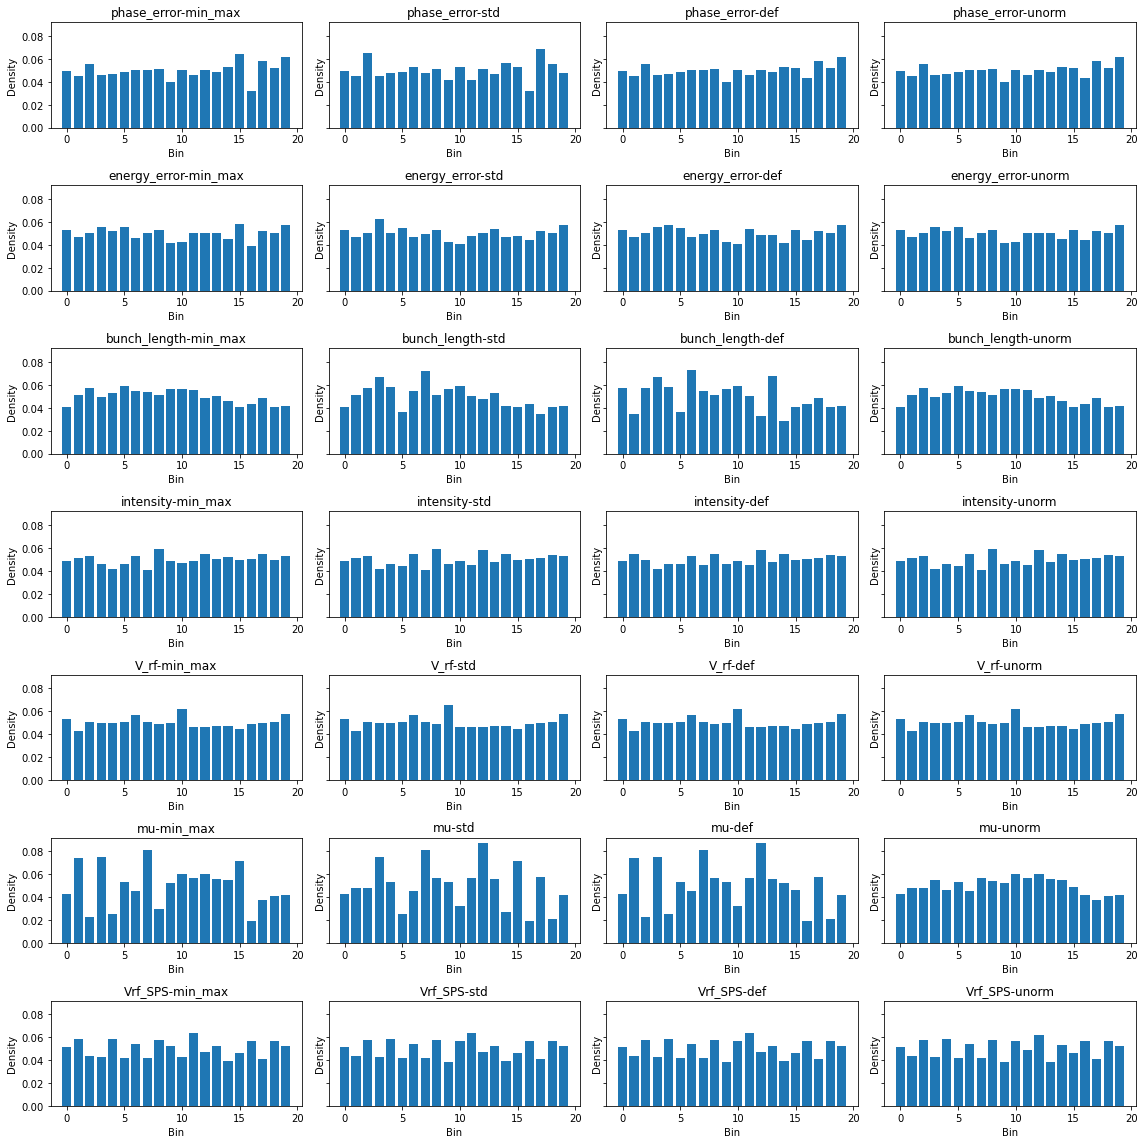

In [8]:
min_max_norm_data = min_max_scaler.transform(y_train)
std_norm_data = std_scaler.transform(y_train)
default_norm_data = normalize_params(
    y_train[:, 0], y_train[:, 1], y_train[:, 2],
    y_train[:, 3], y_train[:, 4], y_train[:, 5], 
    y_train[:, 6])


# Now plot the data distribution
var_names = ['phase_error', 'energy_error',
             'bunch_length', 'intensity', 'V_rf', 'mu', 'Vrf_SPS']
fig, axes = plt.subplots(ncols=4, nrows=len(var_names), sharex=False,
                         sharey=True, figsize=(16, 16))
for i, name in enumerate(var_names):
    hist, edges = np.histogram(min_max_norm_data[:, i], bins=20, density=False)
    hist = hist / len(y_train[:, i])
    print(name+'-min_max', edges)
    ax = axes[i][0]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name + '-min_max')
    # edges = [f'{e:.4f}' for e in edges]
    # plt.xticks(np.arange(len(hist)), edges[1:])
    plt.xlabel('Bin')
    plt.ylabel('Density')
    plt.tight_layout()

    hist, edges = np.histogram(std_norm_data[:, i], bins=20, density=False)
    hist = hist / len(y_train[:, i])
    print(name+'-std', edges)
    ax = axes[i][1]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name + '-std')
    # edges = [f'{e:.4f}' for e in edges]
    # plt.xticks(np.arange(len(hist)), edges[1:])
    plt.xlabel('Bin')
    plt.ylabel('Density')
    plt.tight_layout()

    hist, edges = np.histogram(default_norm_data[i], bins=20, density=False)
    hist = hist / len(y_train[:, i])
    print(name+'-def', edges)
    ax = axes[i][2]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name + '-def')
    # edges = [f'{e:.4f}' for e in edges]
    # plt.xticks(np.arange(len(hist)), edges[1:])
    plt.xlabel('Bin')
    plt.ylabel('Density')
    plt.tight_layout()

    hist, edges = np.histogram(y_train[:, i], bins=20, density=False)
    hist = hist / len(y_train[:, i])
    print(name+'-unorm', edges)
    ax = axes[i][3]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name + '-unorm')
    # edges = [f'{e:.4f}' for e in edges]
    # plt.xticks(np.arange(len(hist)), edges[1:])
    plt.xlabel('Bin')
    plt.ylabel('Density')
    plt.tight_layout()


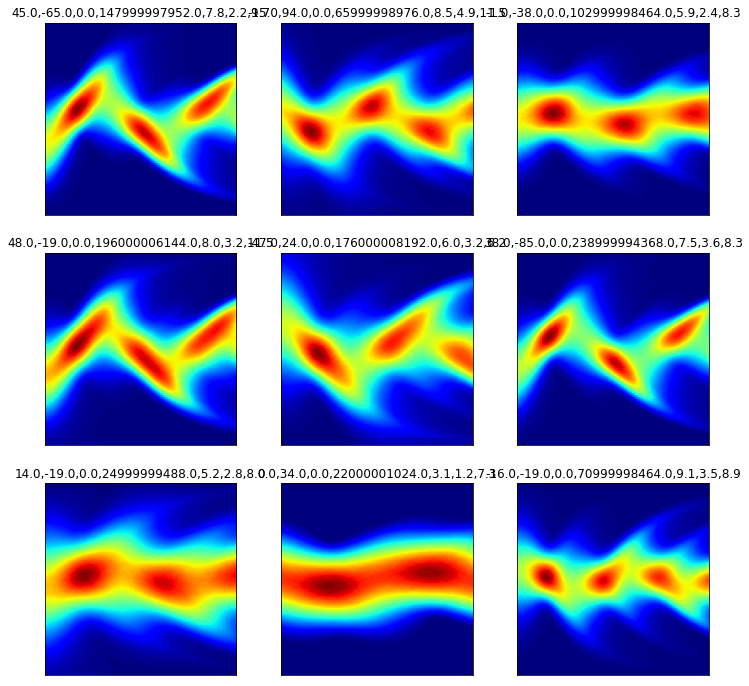

In [20]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i, 14:-14, 14:-14], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [ ]:
# Model instantiation
input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)

eCED = extendedCED(latent_dim, additional_latent_dim, input_shape,
                   filters=cnn_filters)

print(eCED.encoder.summary())



In [ ]:
# Train the encoder
optimizer = tf.keras.optimizers.Adam(train_cfg['encoder']['lr'])

eCED.encoder.compile(optimizer=optimizer, loss='mse')

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, 'encoder'),
                                            monitor='val_loss', save_best_only=True)


In [ ]:
start_time = time.time()
history = eCED.encoder.fit(
    x_train, y_train, epochs=train_cfg['encoder']['epochs'],
    validation_data=(x_valid, y_valid), batch_size=BATCH_SIZE,
    callbacks=[stop_early, save_best])

total_time = time.time() - start_time


In [ ]:
# Plot training and validation loss
train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
          title='Encoder Train/Validation Loss',
          figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))


In [ ]:
# save file with experiment configuration
config_dict = {}
config_dict['encoder'] = {
    'epochs': train_cfg['encoder']['epochs'],
    'lr': train_cfg['encoder']['lr'],
    'dataset_percent': dataset_keep_percent,
    'cnn_filters': list(cnn_filters),
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': len(gpus)
}

# save config_dict
with open(os.path.join(trial_dir, 'encoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)
